In [1]:
# 用来loading和saving models。
import json 
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from IPython import display # 为了render the frames 渲染frames
import seaborn
from collections import deque # 双端队列

%matplotlib inline
seaborn.set()

/home/lily/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 设置游戏过程：
class Catch(object):
    """
    class Catch是真实的游戏过程
    In the game, white tiles(白色的砖块) 从顶部掉落
    goal：通过basket（用white tiles代替）来接fruits。
    action: left:0, stay: 1, right: 2
    """
    
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()
        
    def _update_state(self, action):
        """
        state: f0,f1,basket
            f0,f1: 表示砖块下落的位置
            basktet： 表示basket的位置
        输入： states and actions
        输出： new states and reward
        """
        
        state = self.state
        if action == 0: # 0: left
            action = -1
        elif action == 1: # 1: stay
            action = 0
        else:
            action = 1
            
        f0, f1, basket = state[0]
        # 接砖块的篮子必须放置在grid_size的范围之内，这边要求的范围是[1, self.grid_size-1]
        new_basket = min(max(1, basket+action), self.grid_size - 1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis] #等同于 out[np.newaxis,:]
        
        assert len(out.shape) == 2
        self.state = out
        
    def _draw_state(self):
        """
        给出游戏界面
        """
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        # 画下落的白色砖块的位置
        canvas[state[0], state[1]] = 1
        # 画下面接白色砖块的篮子的位置,在图片的底部，篮子的宽度是3个white tile的宽度
        canvas[-1, state[2]-1: state[2]+2] = 1 
        return canvas
    
    def _get_reward(self):
        """
        回馈reward
        """
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0
        
    def _is_over(self):
        if self.state[0,0] == self.grid_size-1:
            return True
        else:
            return False
    
    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))
    
    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over
    
    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1) #np.random.randint(low,high),[low,high)
        m = np.random.randint(1, self.grid_size-2, size=1) #这里只能够是[1,grid_size-2)的原因是因为basket的长度是3
        self.state = np.asarray([0,n,m])[np.newaxis]
        
        

In [3]:
"""
定义一些variables，用可视化显示
"""
# last_frame_time： 跟踪我们到达哪个frame
last_frame_time = 0
# 将actions转成可读文字
translate_action = ["Left", "Stay", "Right", "Creat Ball", "End Test"]
# 游戏屏幕尺寸(size of the game field)
grid_size = 10

def display_screen(action, points, input_t):
    """
    用于显示game screen(render the game screen)
    """
    
    global last_frame_time
    # print(action)
    print("Action %s, Points: %d"%(translate_action[action],points))
    
    # 只在游戏没有结束的时候显示game screen
    if ("End" not in translate_action[action]):
        plt.imshow(input_t.reshape((grid_size,)*2), interpolation='none', cmap='gray')
        # 删除之前显示的图片,等到接下来的图片可以替代之前的图片的时候
        display.clear_output(wait=True)
        # 显示现在的图片
        display.display(plt.gcf()) #plt.gcf()获得现在图片的查阅
        
    last_frame_time = set_max_fps(last_frame_time,5)

# 之前的函数优点问题，做了细微的修改之后可以运行，这里*1000是为了保证精度吗，
# 自己理解的这个函数的作用是：为了保证每秒最多有FPS帧画面
# FPS是frames per second
# time.time()返回浮点秒数（从1970年开始计数）
# 貌似感觉上面这种实现方法会要稳定一点
def set_max_fps(last_frame_time, FPS=1): 
    current_milli_time = lambda: int(round(time.time()*1000))
    sleep_time = 1.0/FPS - (current_milli_time() - last_frame_time)/1000.
    # print(sleep_time)
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time()
    '''
    current_milli_time = time.time()
    sleep_time = 1.0/FPS - (current_milli_time - last_frame_time)
    print(sleep_time)
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time
    '''
    

In [12]:
"""
NN的输入：<s,a>
NN的输出：Q(s,a)

training process:
experineces: <s,a,r,s'>(s:current state, a:current action, r: instant reward, s': following state)
1. 对每个action计算Q(s',a')(Q值，也就是与state和action都有关的value function)
2. 选取这三个不同action的最大的Q值
3. 计算带有discount factor（衰减因子）:gamma的总的Q值：Q(s,a) = r + gamma*max(Q(s',a'))。这个就是神经网络的目标值
4. 利用loss function: 1//2*(predict_Q(s,a)-target)^2

所有的experience放置在replay memory当中
"""
class ExperienceReplay(): # Python3自动继承object类，所以我后面基本上都省略了
    """
    在gameplay时期的所有的experience<s,a,r,s'>都自动存储在replay memory当中,这里memory是列表
    在训练的时候，在replay memory中的随机抽样batches的experiences作为input和output用来训练
    """
    
    def __init__(self, max_memory=100, discount=.9):
        """
        max_memory: 可以存储的experiences的最大长度
        memory：list of experiences,元素是[experience, game_over(bool)] ,list of list,experience有四个元素
        experience： [游戏初始界面，action, reward, 随后的游戏界面]
        discount: discount factor
        """
        #============================================================================
        # self.max_memory = max_memory
        # self.memory = []
        #============================================================================
        self.memory = deque(maxlen=max_memory)
        self.discount = discount
        
    def remember(self, states, game_over):
        # 将state存储在memory当中
        self.memory.append([states, game_over])
        
        #==============================================================================
        # 这里list是可变长的，所以，需要删除最大长度的，为啥我在这里不用collecttion.queue()来实现呢
        # 简要查了一下相关的，暂时没有找到详细的list和queue的实现，没有比较他们的计算复杂度
        # if len(self.memory) > self.max_memory:
        #     del self.memory[0]
        #==============================================================================
        
    def get_batch(self, model, batch_size=10):
        """
        len_memory: 存储了多少experience
        num_actions: 计算在game中有多少中actions可以被采取
        env_dim: game field的维度
        inputs：batches of inputs([cur_state,action,reward, follwed_state])
        targets: batches of 目标函数
        """
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        # print(self.memory)
        # memory的构成是list of experience,在Catch.obeserve()返回当前图片的时候已经将其转换成一维的
        # 向量，所以这里实际上就是grid_size**2
        env_dim = self.memory[0][0][0].shape[1]
        # print(env_dim)
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):
            """
            state_t: initial state s
            action_t: action taken a
            reward_t: reward earned r
            state_tpl: the state that followed s'
            """
            state_t, action_t, reward_t, state_tpl = self.memory[idx][0]
            game_over = self.memory[idx][1]
            # inputs[i:i+1] = state_t
            inputs[i] = state_t
            # print(model.predict(state_t).shape)
            targets[i] = model.predict(state_t)[0] # model.predict(state_t) 输出的维度是[1，3]
            
            Q_sa = np.max(model.predict(state_tpl)[0])
            
            if game_over:
                targets[i, action_t] = reward_t
            else:
                targets[i, action_t] = reward_t + self.discount * Q_sa
                
        return inputs, targets      

In [13]:
"""
Q-learning: 三层的dense network。
"""
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd

def baseline_model(grid_size, num_actions, hidden_size):
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation="relu"))
    model.add(Dense(hidden_size, activation="relu"))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.1), "mse") # 这里的loss就是均方误差
    return model

"""
模型参数
"""
num_actions = 3
hidden_size = 100
grid_size = 10

model = baseline_model(grid_size, num_actions, hidden_size)
model.summary()

In [15]:
"""
Q-learning的全部的过程，（这里实际上是训练一个策略policy，也就是policy gradient)
DQN（输入是state，输出是每个action的value值，这里输出的这个value值是对应的在这个状态采取这个动作之后总共获得的value的值）
DQN-输入：state，输出：在这个state能够采取不同的action能够获得的最大的value值

这里类似与利用model作为一个simulator（输入是state，输出是action，也就是对DQN的输出取value最大的action），
在simulator的过程当中为了防止只依赖过去的行为而导致之后的行为和之前的行为高度相关，除了利用这个model来做动作的预测之外，
还添加了一些西奥的抖动，也就是随机选取一些动作的过程。这些模拟的动作的过程都存储到experience replay当中（memory当中）

在训练的时候，每次从experience_replay当中取值，目标值就是最大的从当前这个状态开始到游戏结束所获得的总的value值。
模型训练的目的：然个model的输出逼近在这个state能够获得的最大的所有的reward的值。

loss：利用的是MSE
"""
def train(model, epochs, verbose=1):
    """
    训练参数
    """
    epsilon = .1
    max_memory = 500
    batch_size = 1
    
    env = Catch(grid_size)
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    win_cnt = 0
    win_hist = []
    for _ in range(epochs):
        loss = 0.
        env.reset()
        game_over = False
        input_t = env.observe() # 输入是当前游戏的状态图片
        
        while not game_over:
            input_tml = input_t
            
            # 为了防止卡在local minimum，这里加一个小的抖动，避免和之前的行为高度相关，而学习不到其他的行为，而找不到最优解
            # 这边添加的experience replay不也是这个目的吗（replay memory）？
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size=1)[0]
            else:
                q = model.predict(input_tml)
                action = np.argmax(q[0]) # np.argmax()存在相同的最大值，返回第一个最大值位置的index
                
            # print(action)
                
            input_t, reward, game_over = env.act(action)
            if reward == 1:
                win_cnt += 1
                
            # 如果想要可视化训练过程，取消注释
            # display_screen(action, 3000, input_t)
            
            exp_replay.remember([input_tml, action, reward, input_t], game_over)
            
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
            
            batch_loss = model.train_on_batch(inputs, targets)
            
            loss += batch_loss
            
        if verbose > 0:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
        win_hist.append(win_cnt)
        
    return win_hist         

In [16]:
# 训练过程
# playing many games
epoch = 5000
hist = train(model, epoch, verbose=0)
print("Training done")

model.save_weights("model.h5", overwrite=True)
with open("model.json","w") as outfile:
    json.dump(model.to_json(), outfile)

# Testing
def test(model):
    grid_size = 10
    global last_frame_time
    # plt.ion() #打开交互模式（在console当中是默认交互模式，但是在python脚本当中是默认阻塞模式）
    env = Catch(grid_size)
    c = 0
    last_frame_time = 0
    points = 0
    
    for _ in range(10):
        loss = 0.
        env.reset()
        game_over = False
        input_t = env.observe()
        display_screen(3,points, input_t)
        plt.imshow(input_t.reshape((grid_size,)*2),interpolation='none', cmap='gray')
        plt.savefig("%03d.png"%c)
        c += 1
        while not game_over:
            input_tml = input_t
            q = model.predict(input_tml)
            action = np.argmax(q[0])
            input_t, reward, game_over = env.act(action)
            points += reward
            display_screen(action, points, input_t)
            plt.imshow(input_t.reshape((grid_size,)*2), interpolation='none', cmap='gray')
            plt.savefig("%03d.png"%c)
            c += 1
    display_screen(4,points,input_t)

Training done


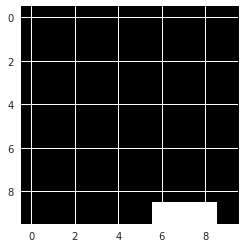

Action End Test, Points: 10


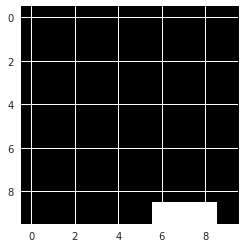

In [20]:
test(model)

In [47]:
print(time.localtime(last_frame_time/1000))
print(time.asctime(time.localtime(last_frame_time/1000)))

time.struct_time(tm_year=2018, tm_mon=5, tm_mday=28, tm_hour=19, tm_min=27, tm_sec=31, tm_wday=0, tm_yday=148, tm_isdst=0)
Mon May 28 19:27:31 2018


In [33]:
"""
从gif图中截取图片
"""
import os
from PIL import Image
# im.title = [(tag,(0,0)+im.size,offset, extra)]
def analyseImage(path):
    im = Image.open(path)
    results = {'size':im.size, 'mode':"full"}
    try:
        while True:
            if im.tile: # im.tile是2-tuple的整数
                # print(im.tile) #[('gif', (0, 0, 432, 288), 819, (8, False))]
                tile = im.tile[0]
                update_region = tile[1]
                update_region_dimensions = update_region[2:]
                if update_region_dimensions != im.size:
                    results["mode"] = "partial"
                    break
            im.seek(im.tell()+1)
    except EOFError:
        pass
    return results

def processImage(path):
    """
    迭代GIF，获得每帧
    """
    mode = analyseImage(path)["mode"]
    
    im = Image.open(path)
    
    i = 0
    p = im.getpalette() # 返回image palette的list，也就是一个list的collor的值
    last_frame = im.convert('RGBA')
    
    try:
        while True:
            print("saving %s (%s) frame %d, %s %s" % (path, mode, i, im.size, im.tile) )
            '''
            如果说GIF用本地color table，每个帧会有自己的palette， 如果不是，我们需要apply global palette到新的frame
            '''
            if not im.getpalette():
                im.putpalette(p)
                
            new_frame = Image.new("RGBA",im.size)
            """
            如果说是"partial"mode, 这个时候每帧update的region不是原来的图片大小，所以需要构建一个在原来的图片上面的新的frame
            """
            if mode == "partial":
                new_frame.paste(last_frame)
                
            new_frame.paste(im, (0,0), im.convert("RGBA")) # Image.paste(im, box=None, mask=None):box:4-tuple,如果是2-tuple代表左上角，如果一个图片作为第二个参数，并且没有第三个参数，box默认是(0,0)
            new_frame.save('Datageek/%s-%d.png' % (''.join(os.path.basename(path).split('.')[:-1]), i), 'PNG') #这里去除后面的.gif
            
            i += 1
            last_frame = new_frame
            # 读取gif图，支持seek()和tell()方法，查找下一帧通过im.seek(im.tell()+1),或者是逆序查找到第一帧，但是不支持随机帧搜索
            # im.seek()当seek到最后一帧的时候会raise一个EOFError。
            im.seek(im.tell()+1)
            
    except EOFError:
        pass
    
def main():  
    processImage('catch_game.gif')  
    
if __name__ == "__main__":
    main()

[('gif', (0, 0, 432, 288), 819, (8, False))]
[('gif', (0, 0, 432, 288), 20958, (8, False))]
[('gif', (0, 0, 432, 288), 41250, (8, False))]
[('gif', (0, 0, 432, 288), 61389, (8, False))]
[('gif', (0, 0, 432, 288), 81706, (8, False))]
[('gif', (0, 0, 432, 288), 101845, (8, False))]
[('gif', (0, 0, 432, 288), 122137, (8, False))]
[('gif', (0, 0, 432, 288), 142232, (8, False))]
[('gif', (0, 0, 432, 288), 162524, (8, False))]
[('gif', (0, 0, 432, 288), 182662, (8, False))]
[('gif', (0, 0, 432, 288), 202695, (8, False))]
[('gif', (0, 0, 432, 288), 222850, (8, False))]
[('gif', (0, 0, 432, 288), 242898, (8, False))]
[('gif', (0, 0, 432, 288), 262979, (8, False))]
[('gif', (0, 0, 432, 288), 283027, (8, False))]
[('gif', (0, 0, 432, 288), 303108, (8, False))]
[('gif', (0, 0, 432, 288), 323244, (8, False))]
[('gif', (0, 0, 432, 288), 343292, (8, False))]
[('gif', (0, 0, 432, 288), 363369, (8, False))]
[('gif', (0, 0, 432, 288), 383417, (8, False))]
[('gif', (0, 0, 432, 288), 403465, (8, False))]

saving catch_game.gif (full) frame 50, (432, 288) [('gif', (0, 0, 432, 288), 1006016, (8, False))]
saving catch_game.gif (full) frame 51, (432, 288) [('gif', (0, 0, 432, 288), 1026155, (8, False))]
saving catch_game.gif (full) frame 52, (432, 288) [('gif', (0, 0, 432, 288), 1046448, (8, False))]
saving catch_game.gif (full) frame 53, (432, 288) [('gif', (0, 0, 432, 288), 1066547, (8, False))]
saving catch_game.gif (full) frame 54, (432, 288) [('gif', (0, 0, 432, 288), 1086716, (8, False))]
saving catch_game.gif (full) frame 55, (432, 288) [('gif', (0, 0, 432, 288), 1106855, (8, False))]
saving catch_game.gif (full) frame 56, (432, 288) [('gif', (0, 0, 432, 288), 1126994, (8, False))]
saving catch_game.gif (full) frame 57, (432, 288) [('gif', (0, 0, 432, 288), 1147133, (8, False))]
saving catch_game.gif (full) frame 58, (432, 288) [('gif', (0, 0, 432, 288), 1167271, (8, False))]
saving catch_game.gif (full) frame 59, (432, 288) [('gif', (0, 0, 432, 288), 1187564, (8, False))]
saving cat

In [28]:
"""
gif图合成
"""
import imageio
def create_gif(image_list, gif_name):
    frames = []
    for image_name in image_list:
        frames.append(imageio.imread(image_name))
    # Save them as frames into gif
    imageio.mimsave(gif_name, frames, 'GIF', duration=0.1) # duration:每一帧的间隔
    
    return

def main():
    image_list = ["%03d.png"%i for i in range(100)]
    gif_name = "catch_game.gif"
    create_gif(image_list, gif_name)
    
if __name__ == "__main__":
    main()

In [32]:
def main():  
    processImage('catch_game.gif')  
    
main()

saving catch_game.gif (full) frame 0, (432, 288) []
saving catch_game.gif (full) frame 1, (432, 288) [('gif', (0, 0, 432, 288), 20958, (8, False))]
saving catch_game.gif (full) frame 2, (432, 288) [('gif', (0, 0, 432, 288), 41250, (8, False))]
saving catch_game.gif (full) frame 3, (432, 288) [('gif', (0, 0, 432, 288), 61389, (8, False))]
saving catch_game.gif (full) frame 4, (432, 288) [('gif', (0, 0, 432, 288), 81706, (8, False))]
saving catch_game.gif (full) frame 5, (432, 288) [('gif', (0, 0, 432, 288), 101845, (8, False))]
saving catch_game.gif (full) frame 6, (432, 288) [('gif', (0, 0, 432, 288), 122137, (8, False))]
saving catch_game.gif (full) frame 7, (432, 288) [('gif', (0, 0, 432, 288), 142232, (8, False))]
saving catch_game.gif (full) frame 8, (432, 288) [('gif', (0, 0, 432, 288), 162524, (8, False))]
saving catch_game.gif (full) frame 9, (432, 288) [('gif', (0, 0, 432, 288), 182662, (8, False))]
saving catch_game.gif (full) frame 10, (432, 288) [('gif', (0, 0, 432, 288), 20

In [92]:
a[0]

array([1, 2, 2])

In [93]:
np.argmax(a[0])

1

In [22]:
a = [1, 2, 2]

In [25]:
a[:]

[1, 2, 2]